In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
from datasets import load_dataset

ds = load_dataset("rishitdagli/cppe-5")

README.md:   0%|          | 0.00/11.2k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/237M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/4.14M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/29 [00:00<?, ? examples/s]

In [3]:
train = ds['train']
test = ds['test']

In [9]:
category_id_to_name = {
    0: 'Coverall',
    1: 'Face_Shield',
    2: 'Gloves',
    3: 'Goggles',
    4: 'Mask'
}

In [49]:
#Inspecting the sample
from pprint import pprint

sample = train[0]
pprint(sample)


{'height': 663,
 'image': <PIL.Image.Image image mode=RGB size=943x663 at 0x7FF0B199C190>,
 'image_id': 15,
 'objects': {'area': [3796, 1596, 152768, 81002],
             'bbox': [[302.0, 109.0, 73.0, 52.0],
                      [810.0, 100.0, 57.0, 28.0],
                      [160.0, 31.0, 248.0, 616.0],
                      [741.0, 68.0, 202.0, 401.0]],
             'category': [4, 4, 0, 0],
             'id': [114, 115, 116, 117]},
 'width': 943}


In [10]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

def display_sample(sample):
    image = sample['image']

    if not isinstance(image, np.ndarray):
        image = np.array(image)
    

    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.imshow(image)
    plt.axis('off')
    
    # Checking if 'objects' contain annotations
    if 'objects' in sample and sample['objects']:
        objects = sample['objects']
        
        # Extract bounding boxes and categories
        bboxes = objects.get('bbox', [])
        categories = objects.get('category', [])
        
        for i in range(len(bboxes)):
            bbox = bboxes[i]
            category_id = categories[i]
            category_name = category_id_to_name.get(category_id, 'Unknown')
            
            xmin, ymin, width, height = bbox
            rect = patches.Rectangle(
                (xmin, ymin),
                width,
                height,
                linewidth=2,
                edgecolor='red',
                facecolor='none'
            )
            ax.add_patch(rect)
            # Adding text to the boxes to identify predictions
            ax.text(
                xmin,
                ymin - 5,
                category_name,
                fontsize=12,
                color='white',
                bbox=dict(facecolor='red', alpha=0.5)
            )
    plt.show()



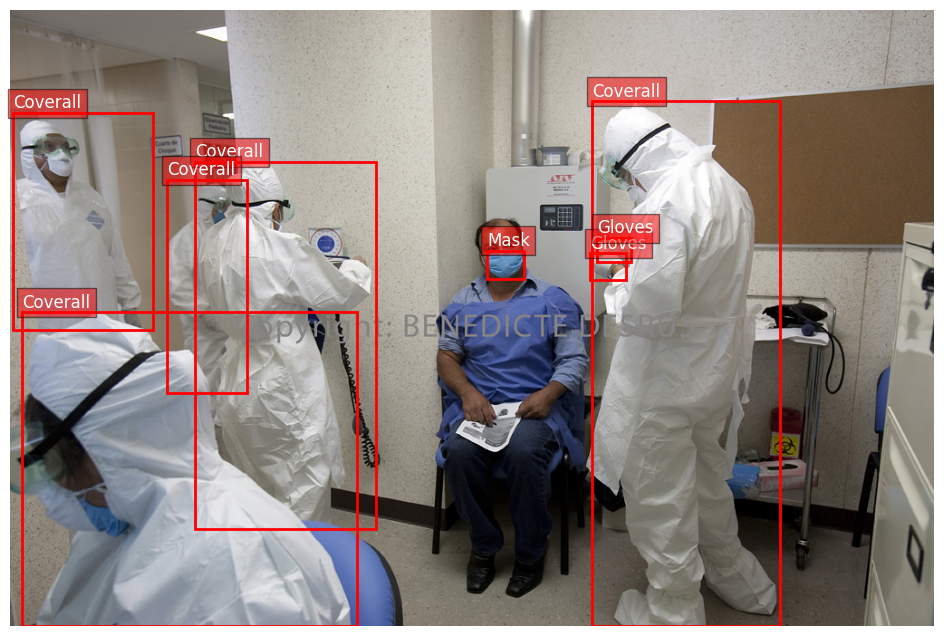

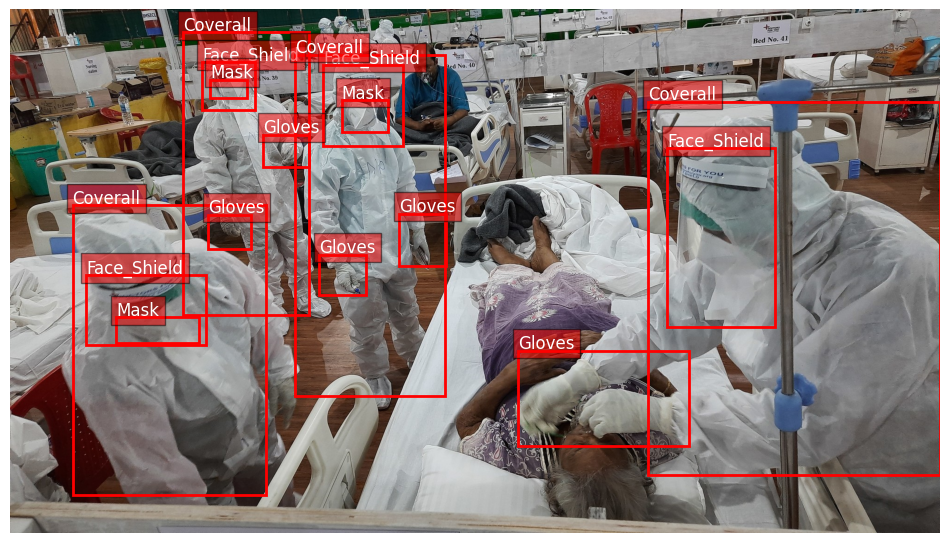

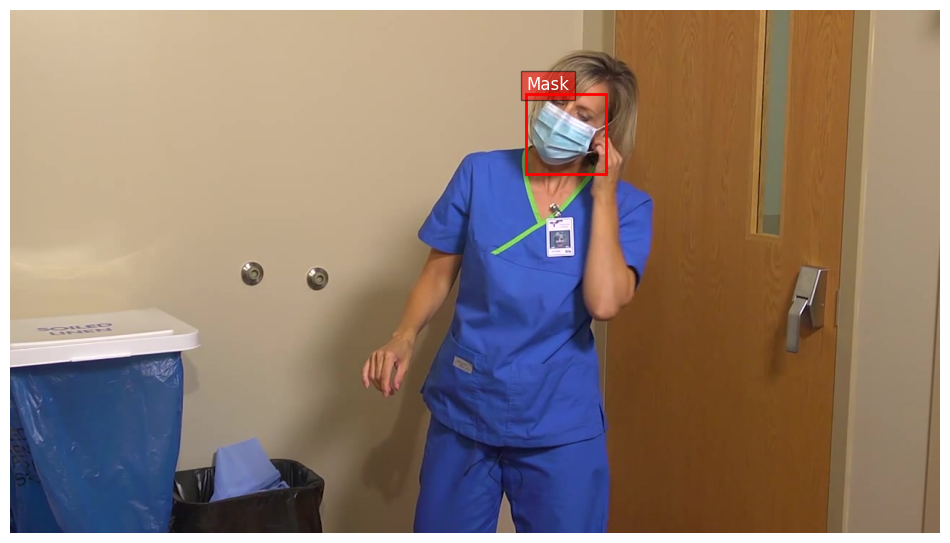

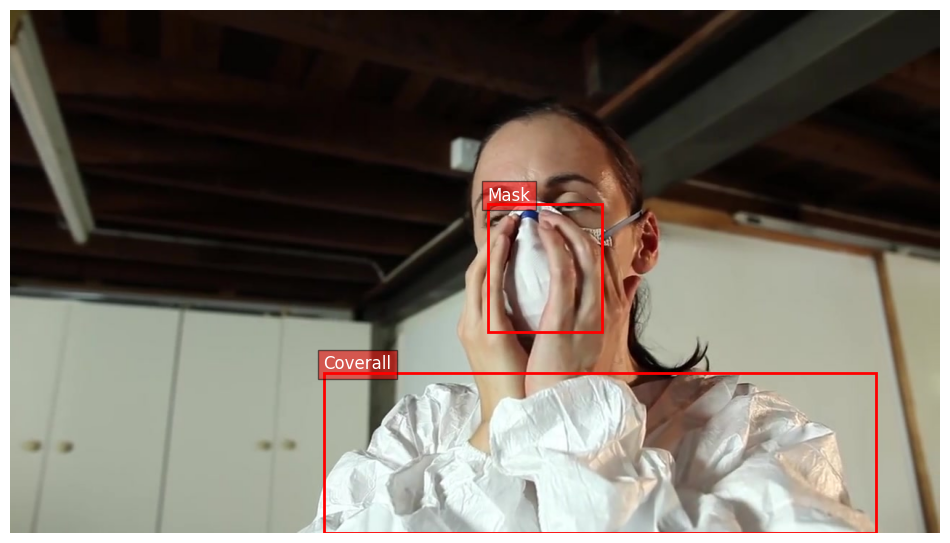

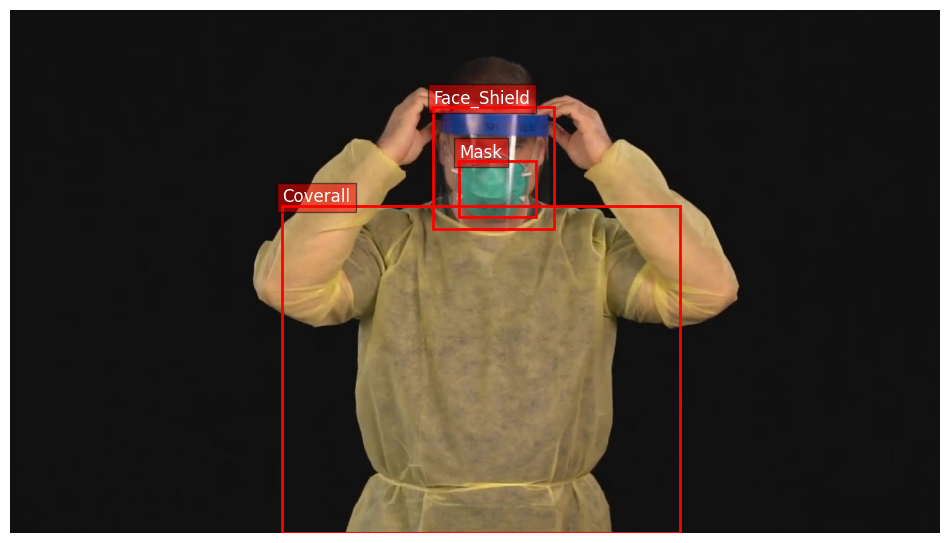

In [11]:
import random

for _ in range(5):
    idx = random.randint(0, len(train) - 1)
    sample = train[idx]
    display_sample(sample)



In [13]:
!pip install -q ultralytics pycocotools


In [18]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tqdm import tqdm
from PIL import Image

from datasets import load_dataset
from ultralytics import YOLO
os.makedirs('/kaggle/working/datasets/images/train', exist_ok=True)
os.makedirs('/kaggle/working/datasets/labels/train', exist_ok=True)
os.makedirs('/kaggle/working/datasets/images/val', exist_ok=True)
os.makedirs('/kaggle/working/datasets/labels/val', exist_ok=True)


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [25]:
def save_yolo_labels(dataset, split):
    image_dir = f'/kaggle/working/datasets/images/{split}'
    label_dir = f'/kaggle/working/datasets/labels/{split}'
    os.makedirs(image_dir, exist_ok=True)
    os.makedirs(label_dir, exist_ok=True)
    
    for idx in tqdm(range(len(dataset)), desc=f"Processing {split} data"):
        sample = dataset[idx]
        image = sample['image']
        image_id = sample['image_id']
        
        # **Convert image to RGB if necessary**
        if image.mode != 'RGB':
            image = image.convert('RGB')
        
        # Save image
        image_filename = f"{image_id}.jpg"
        image_path = os.path.join(image_dir, image_filename)
        image.save(image_path)
        
        # Preparing label file content
        label_lines = []
        
        if 'objects' in sample and sample['objects']:
            objects = sample['objects']
            bboxes = objects.get('bbox', [])
            categories = objects.get('category', [])
            
            for i in range(len(bboxes)):
                bbox = bboxes[i]
                category_id = categories[i]
                class_id = category_id  
                
                # Converting bbox to YOLO format
                xmin, ymin, width, height = bbox
                x_center = xmin + width / 2
                y_center = ymin + height / 2
                img_width, img_height = sample['width'], sample['height']
                x_center /= img_width
                y_center /= img_height
                width /= img_width
                height /= img_height
                
                # Creating label line
                label_line = f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}"
                label_lines.append(label_line)
        
        # Saving label file
        label_filename = f"{image_id}.txt"
        label_path = os.path.join(label_dir, label_filename)
        with open(label_path, 'w') as f:
            f.write('\n'.join(label_lines))

save_yolo_labels(train, 'train')
save_yolo_labels(test, 'val')


Processing val data: 100%|██████████| 29/29 [00:00<00:00, 91.31it/s] 


In [26]:
data_yaml = """
path: /kaggle/working/datasets  # Root directory of your dataset
train: images/train
val: images/val

# Number of classes
nc: 5

# Class names
names: ['Coverall', 'Face_Shield', 'Gloves', 'Goggles', 'Mask']
"""

# Saving the YAML file
with open('/kaggle/working/cppe5.yaml', 'w') as f:
    f.write(data_yaml)


In [27]:
from ultralytics import YOLO

model = YOLO('yolov8n.pt')  

model.train(data='cppe5.yaml', epochs=50, imgsz=640, batch=16)


100%|██████████| 6.25M/6.25M [00:00<00:00, 106MB/s]


Ultralytics 8.3.23 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=cppe5.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, lin

100%|██████████| 755k/755k [00:00<00:00, 17.6MB/s]
2024-10-27 17:38:06,674	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-10-27 17:38:07,099	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


Overriding model.yaml nc=80 with nc=5

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 87.2MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/working/datasets/labels/train... 1000 images, 0 backgrounds, 16 corrupt: 100%|██████████| 1000/1000 [00:00<00:00, 1127.88it/s]

train: WARNING ⚠️ /kaggle/working/datasets/images/train/211.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.5378]
train: WARNING ⚠️ /kaggle/working/datasets/images/train/218.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     3.5741      1.2593      3.3241      1.1674      3.7963      2.3163]
train: WARNING ⚠️ /kaggle/working/datasets/images/train/237.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [        1.1      1.0867]
train: WARNING ⚠️ /kaggle/working/datasets/images/train/265.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.2275]
train: WARNING ⚠️ /kaggle/working/datasets/images/train/266.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0322]
train: WARNING ⚠️ /kaggle/working/datasets/images/train/271.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.6464      1.3425

train: New cache created: /kaggle/working/datasets/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.20 (you have 1.4.17). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /kaggle/working/datasets/labels/val... 29 images, 0 backgrounds, 0 corrupt: 100%|██████████| 29/29 [00:00<00:00, 12996.56it/s]

val: New cache created: /kaggle/working/datasets/labels/val.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001111, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      2.43G      1.565      2.698      1.566         74        640: 100%|██████████| 62/62 [00:13<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.42s/it]

                   all         29        207      0.976      0.167      0.466      0.265



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      2.31G      1.518      1.798      1.505         73        640: 100%|██████████| 62/62 [00:12<00:00,  5.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.01it/s]

                   all         29        207      0.591      0.405       0.48      0.286



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      2.33G      1.521      1.638      1.497         65        640: 100%|██████████| 62/62 [00:11<00:00,  5.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.29it/s]

                   all         29        207      0.533      0.511      0.522      0.323



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      2.41G      1.511      1.595      1.491         63        640: 100%|██████████| 62/62 [00:12<00:00,  5.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.30it/s]

                   all         29        207      0.692      0.654      0.705       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      2.33G      1.489      1.492      1.459         40        640: 100%|██████████| 62/62 [00:11<00:00,  5.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.44it/s]

                   all         29        207      0.737      0.654       0.76      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      2.46G      1.471       1.41      1.442         65        640: 100%|██████████| 62/62 [00:12<00:00,  5.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.60it/s]

                   all         29        207      0.831      0.726      0.786      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      2.33G      1.477      1.401      1.456         68        640: 100%|██████████| 62/62 [00:12<00:00,  5.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.92it/s]

                   all         29        207       0.75      0.694      0.776      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      2.38G       1.42      1.312       1.41         92        640: 100%|██████████| 62/62 [00:11<00:00,  5.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.42it/s]

                   all         29        207       0.78      0.672      0.765      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      2.38G      1.435      1.278       1.41         34        640: 100%|██████████| 62/62 [00:12<00:00,  5.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.72it/s]

                   all         29        207      0.911      0.701      0.841      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      2.33G      1.382      1.223      1.388         65        640: 100%|██████████| 62/62 [00:11<00:00,  5.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.44it/s]

                   all         29        207      0.832      0.757      0.835      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50       2.4G      1.373      1.208      1.387         94        640: 100%|██████████| 62/62 [00:12<00:00,  5.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.56it/s]

                   all         29        207      0.838      0.745      0.837      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      2.38G      1.327      1.142      1.353         74        640: 100%|██████████| 62/62 [00:11<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.62it/s]

                   all         29        207      0.871      0.767      0.844      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      2.37G      1.358       1.14      1.364         55        640: 100%|██████████| 62/62 [00:11<00:00,  5.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.43it/s]

                   all         29        207      0.854      0.728      0.844      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50       2.4G      1.341      1.144      1.358         67        640: 100%|██████████| 62/62 [00:12<00:00,  5.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.68it/s]

                   all         29        207      0.817      0.751      0.843      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      2.38G      1.335      1.117      1.355        106        640: 100%|██████████| 62/62 [00:11<00:00,  5.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.79it/s]

                   all         29        207      0.817      0.727      0.839      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50       2.4G      1.316      1.097      1.338         86        640: 100%|██████████| 62/62 [00:12<00:00,  5.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.73it/s]

                   all         29        207      0.841      0.757      0.854      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      2.33G      1.323      1.081      1.345         86        640: 100%|██████████| 62/62 [00:11<00:00,  5.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.74it/s]


                   all         29        207      0.853      0.789      0.838      0.537

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      2.39G      1.278      1.046      1.315         82        640: 100%|██████████| 62/62 [00:11<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.15it/s]


                   all         29        207      0.868      0.665      0.848      0.547

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      2.46G      1.305       1.04       1.32         81        640: 100%|██████████| 62/62 [00:12<00:00,  5.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.68it/s]

                   all         29        207       0.83      0.786      0.858      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      2.39G      1.261      1.021      1.301         71        640: 100%|██████████| 62/62 [00:11<00:00,  5.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.75it/s]


                   all         29        207      0.883      0.821      0.888      0.571

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      2.38G      1.263      1.002      1.301         61        640: 100%|██████████| 62/62 [00:12<00:00,  5.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.36it/s]

                   all         29        207       0.83       0.79      0.862       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      2.38G      1.239      1.005      1.294         61        640: 100%|██████████| 62/62 [00:11<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.81it/s]

                   all         29        207      0.895      0.768      0.878      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      2.41G      1.244      0.968      1.279         74        640: 100%|██████████| 62/62 [00:11<00:00,  5.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.49it/s]

                   all         29        207      0.885      0.812      0.885      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      2.33G      1.218     0.9412      1.288         72        640: 100%|██████████| 62/62 [00:12<00:00,  5.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.82it/s]

                   all         29        207      0.851      0.821       0.87      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      2.33G        1.2       0.93      1.263         56        640: 100%|██████████| 62/62 [00:11<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.32it/s]

                   all         29        207      0.904      0.786      0.879      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      2.38G      1.236     0.9427      1.278         68        640: 100%|██████████| 62/62 [00:12<00:00,  5.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.67it/s]

                   all         29        207      0.909      0.816      0.895      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50       2.4G      1.203     0.9206      1.264         46        640: 100%|██████████| 62/62 [00:12<00:00,  5.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.58it/s]

                   all         29        207      0.875       0.81      0.884      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      2.39G      1.182     0.9049      1.263         44        640: 100%|██████████| 62/62 [00:11<00:00,  5.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.67it/s]

                   all         29        207       0.91      0.837      0.892      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      2.33G      1.175     0.8715       1.24         57        640: 100%|██████████| 62/62 [00:12<00:00,  5.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.72it/s]

                   all         29        207      0.873      0.836      0.893      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      2.39G      1.157     0.8729      1.231         95        640: 100%|██████████| 62/62 [00:11<00:00,  5.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.34it/s]

                   all         29        207      0.856      0.832      0.902      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      2.33G      1.166     0.8793      1.239         54        640: 100%|██████████| 62/62 [00:12<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.59it/s]

                   all         29        207      0.874      0.765      0.872      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      2.41G      1.137     0.8393      1.227         46        640: 100%|██████████| 62/62 [00:11<00:00,  5.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.43it/s]

                   all         29        207      0.913      0.769      0.891      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50       2.4G      1.116     0.8323      1.213         60        640: 100%|██████████| 62/62 [00:11<00:00,  5.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.85it/s]

                   all         29        207      0.891      0.787      0.885       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      2.41G      1.116     0.8255      1.211         71        640: 100%|██████████| 62/62 [00:12<00:00,  5.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.51it/s]

                   all         29        207      0.893      0.817      0.896      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      2.33G       1.14     0.8307      1.225         49        640: 100%|██████████| 62/62 [00:11<00:00,  5.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.60it/s]

                   all         29        207      0.884        0.8      0.886      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      2.38G      1.127     0.8128       1.22         59        640: 100%|██████████| 62/62 [00:12<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.59it/s]

                   all         29        207      0.892      0.805      0.878      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      2.33G      1.139     0.8397      1.207         41        640: 100%|██████████| 62/62 [00:11<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.11it/s]

                   all         29        207      0.878      0.849      0.893      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      2.42G      1.101     0.8009      1.215         67        640: 100%|██████████| 62/62 [00:11<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.12it/s]

                   all         29        207      0.924      0.801      0.897      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      2.38G      1.098     0.7959      1.196        120        640: 100%|██████████| 62/62 [00:12<00:00,  5.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.18it/s]

                   all         29        207      0.878      0.819       0.88      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      2.48G      1.091     0.7872      1.192        103        640: 100%|██████████| 62/62 [00:11<00:00,  5.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.68it/s]

                   all         29        207      0.877      0.794      0.876      0.562


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      2.38G      1.086     0.7696      1.226         24        640: 100%|██████████| 62/62 [00:13<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.70it/s]

                   all         29        207      0.833      0.774      0.844      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      2.33G      1.074     0.7379      1.197         46        640: 100%|██████████| 62/62 [00:11<00:00,  5.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.66it/s]

                   all         29        207      0.885      0.801      0.877      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      2.33G      1.038     0.7204      1.176         28        640: 100%|██████████| 62/62 [00:11<00:00,  5.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.25it/s]

                   all         29        207      0.881      0.803      0.876      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50       2.4G      1.034     0.7112      1.195         34        640: 100%|██████████| 62/62 [00:11<00:00,  5.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.85it/s]

                   all         29        207      0.849      0.801       0.87      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      2.33G      1.027      0.698       1.18         62        640: 100%|██████████| 62/62 [00:11<00:00,  5.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.59it/s]

                   all         29        207      0.896      0.776      0.876      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      2.33G      1.009     0.6858      1.165         20        640: 100%|██████████| 62/62 [00:11<00:00,  5.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.93it/s]

                   all         29        207      0.892      0.753      0.854      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      2.38G      1.017     0.6944      1.175         24        640: 100%|██████████| 62/62 [00:11<00:00,  5.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.89it/s]

                   all         29        207      0.894      0.771      0.857      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      2.33G     0.9931     0.6744      1.156         47        640: 100%|██████████| 62/62 [00:11<00:00,  5.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.22it/s]

                   all         29        207      0.866      0.797      0.872      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      2.33G     0.9883     0.6791       1.16         61        640: 100%|██████████| 62/62 [00:11<00:00,  5.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.75it/s]

                   all         29        207      0.875      0.775      0.865      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      2.33G     0.9841     0.6531      1.141         47        640: 100%|██████████| 62/62 [00:11<00:00,  5.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.35it/s]

                   all         29        207      0.876      0.777       0.86      0.539



50 epochs completed in 0.185 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.3MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.3MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.23 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 168 layers, 3,006,623 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.88it/s]


                   all         29        207      0.908      0.838      0.892      0.588
              Coverall         25         45      0.845      0.849      0.895      0.678
           Face_Shield         14         17      0.872      0.941      0.951      0.655
                Gloves         22         61      0.884      0.627      0.794      0.502
               Goggles         18         32      0.952      0.906      0.914      0.512
                  Mask         26         52      0.985      0.865      0.906      0.592
Speed: 0.2ms preprocess, 2.0ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7ff0f6687160>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
        

In [29]:
model = YOLO('/kaggle/working/yolo11n.pt')  

model.train(data='cppe5.yaml', epochs=50, imgsz=640, batch=16)

Ultralytics 8.3.23 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=/kaggle/working/yolo11n.pt, data=cppe5.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, sho

train: Scanning /kaggle/working/datasets/labels/train.cache... 1000 images, 0 backgrounds, 16 corrupt: 100%|██████████| 1000/1000 [00:00<?, ?it/s]

train: WARNING ⚠️ /kaggle/working/datasets/images/train/211.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.5378]
train: WARNING ⚠️ /kaggle/working/datasets/images/train/218.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     3.5741      1.2593      3.3241      1.1674      3.7963      2.3163]
train: WARNING ⚠️ /kaggle/working/datasets/images/train/237.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [        1.1      1.0867]
train: WARNING ⚠️ /kaggle/working/datasets/images/train/265.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.2275]
train: WARNING ⚠️ /kaggle/working/datasets/images/train/266.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0322]
train: WARNING ⚠️ /kaggle/working/datasets/images/train/271.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.6464      1.3425


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /kaggle/working/datasets/labels/val.cache... 29 images, 0 backgrounds, 0 corrupt: 100%|██████████| 29/29 [00:00<?, ?it/s]


Plotting labels to runs/detect/train2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001111, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/train2
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      2.69G      1.573      3.051      1.541         74        640: 100%|██████████| 62/62 [00:15<00:00,  4.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.41it/s]

                   all         29        207     0.0166      0.457      0.248      0.172



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50       2.7G      1.559      1.935      1.526         73        640: 100%|██████████| 62/62 [00:14<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.96it/s]

                   all         29        207      0.744      0.374      0.495      0.282



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      2.63G       1.53      1.696      1.507         65        640: 100%|██████████| 62/62 [00:13<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.08it/s]


                   all         29        207      0.538      0.359      0.473      0.257

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      2.63G      1.532      1.633      1.509         63        640: 100%|██████████| 62/62 [00:13<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.27it/s]


                   all         29        207       0.76      0.598       0.68      0.381

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      2.63G      1.521      1.551      1.499         40        640: 100%|██████████| 62/62 [00:13<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.33it/s]


                   all         29        207      0.753      0.593      0.734      0.429

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      2.67G      1.483      1.468      1.469         65        640: 100%|██████████| 62/62 [00:13<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.15it/s]

                   all         29        207      0.663      0.658      0.682      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      2.69G      1.488      1.438      1.472         68        640: 100%|██████████| 62/62 [00:13<00:00,  4.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.33it/s]

                   all         29        207      0.739      0.519       0.67      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      2.62G      1.437      1.369      1.432         92        640: 100%|██████████| 62/62 [00:13<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.44it/s]

                   all         29        207      0.811      0.716      0.816      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      2.62G      1.442      1.311      1.426         34        640: 100%|██████████| 62/62 [00:13<00:00,  4.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.63it/s]

                   all         29        207      0.731      0.727      0.812      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      2.63G      1.411      1.271      1.412         65        640: 100%|██████████| 62/62 [00:13<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.60it/s]

                   all         29        207       0.82      0.749       0.83      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      2.63G      1.387      1.249      1.408         94        640: 100%|██████████| 62/62 [00:13<00:00,  4.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.64it/s]

                   all         29        207      0.859      0.747      0.844      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      2.66G      1.354      1.194      1.378         74        640: 100%|██████████| 62/62 [00:13<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.66it/s]

                   all         29        207      0.887      0.597      0.763      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      2.62G      1.382      1.197      1.386         55        640: 100%|██████████| 62/62 [00:13<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.50it/s]

                   all         29        207       0.87      0.759      0.845      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      2.66G       1.36      1.168      1.377         67        640: 100%|██████████| 62/62 [00:13<00:00,  4.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.36it/s]

                   all         29        207      0.848      0.703       0.82      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      2.63G      1.362      1.159      1.381        106        640: 100%|██████████| 62/62 [00:13<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.71it/s]


                   all         29        207      0.787      0.763       0.83      0.499

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      2.66G       1.33      1.121       1.35         86        640: 100%|██████████| 62/62 [00:13<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.26it/s]

                   all         29        207      0.821      0.721      0.825      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      2.69G      1.337      1.127      1.355         86        640: 100%|██████████| 62/62 [00:13<00:00,  4.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.82it/s]


                   all         29        207      0.833      0.765      0.844      0.533

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      2.65G      1.305      1.082      1.333         82        640: 100%|██████████| 62/62 [00:13<00:00,  4.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.56it/s]

                   all         29        207      0.786      0.659      0.774      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      2.66G      1.323      1.075      1.338         81        640: 100%|██████████| 62/62 [00:13<00:00,  4.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.45it/s]

                   all         29        207      0.871       0.78      0.873      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      2.64G      1.291      1.053      1.327         71        640: 100%|██████████| 62/62 [00:13<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.72it/s]

                   all         29        207      0.866      0.775      0.868      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      2.62G      1.287      1.035      1.322         61        640: 100%|██████████| 62/62 [00:13<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.58it/s]

                   all         29        207      0.853      0.762      0.858      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      2.62G      1.269       1.04      1.312         61        640: 100%|██████████| 62/62 [00:13<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.54it/s]

                   all         29        207      0.853      0.775      0.893      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      2.65G      1.258      1.002      1.299         74        640: 100%|██████████| 62/62 [00:13<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.46it/s]

                   all         29        207      0.805      0.781      0.858      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      2.69G      1.229     0.9695      1.307         72        640: 100%|██████████| 62/62 [00:13<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.56it/s]

                   all         29        207      0.904      0.755       0.87      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      2.69G      1.227     0.9626      1.284         56        640: 100%|██████████| 62/62 [00:13<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.28it/s]

                   all         29        207      0.869      0.758      0.862      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      2.66G      1.258     0.9831      1.297         68        640: 100%|██████████| 62/62 [00:13<00:00,  4.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.70it/s]


                   all         29        207      0.942        0.8      0.891      0.563

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      2.64G      1.228     0.9513      1.283         46        640: 100%|██████████| 62/62 [00:13<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.68it/s]

                   all         29        207      0.899      0.821        0.9      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      2.65G      1.204     0.9345      1.284         44        640: 100%|██████████| 62/62 [00:13<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.76it/s]

                   all         29        207      0.845      0.782      0.874      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      2.69G      1.202     0.9178      1.261         57        640: 100%|██████████| 62/62 [00:13<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.44it/s]

                   all         29        207       0.88      0.795      0.872      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      2.63G      1.178     0.9103      1.253         95        640: 100%|██████████| 62/62 [00:13<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.32it/s]

                   all         29        207      0.854      0.782      0.895      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      2.63G      1.188     0.9128      1.262         54        640: 100%|██████████| 62/62 [00:13<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.58it/s]

                   all         29        207      0.882      0.776      0.878      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      2.64G      1.164     0.8823      1.253         46        640: 100%|██████████| 62/62 [00:13<00:00,  4.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.85it/s]

                   all         29        207      0.845      0.835      0.878      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      2.63G      1.136     0.8655      1.231         60        640: 100%|██████████| 62/62 [00:13<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.80it/s]


                   all         29        207      0.831      0.836      0.879      0.566

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      2.63G      1.146     0.8551      1.233         71        640: 100%|██████████| 62/62 [00:14<00:00,  4.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.26it/s]

                   all         29        207      0.845      0.814      0.904      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      2.63G      1.172     0.8643      1.247         49        640: 100%|██████████| 62/62 [00:13<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.82it/s]

                   all         29        207       0.87      0.808      0.889      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      2.63G      1.147     0.8468      1.237         59        640: 100%|██████████| 62/62 [00:13<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.43it/s]

                   all         29        207      0.881      0.775      0.883      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      2.63G       1.18     0.8716      1.237         41        640: 100%|██████████| 62/62 [00:13<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.43it/s]

                   all         29        207      0.853      0.868      0.906      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      2.65G      1.141     0.8416      1.237         67        640: 100%|██████████| 62/62 [00:13<00:00,  4.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.95it/s]

                   all         29        207      0.806      0.792       0.85      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      2.63G      1.126     0.8308      1.214        120        640: 100%|██████████| 62/62 [00:13<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.57it/s]

                   all         29        207      0.844      0.779      0.863      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      2.69G      1.119     0.8234      1.211        103        640: 100%|██████████| 62/62 [00:13<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.46it/s]

                   all         29        207      0.884      0.794      0.905      0.591


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      2.64G      1.103      0.799      1.238         24        640: 100%|██████████| 62/62 [00:15<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.14it/s]


                   all         29        207      0.833      0.767       0.83      0.511

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      2.66G      1.092     0.7684      1.216         46        640: 100%|██████████| 62/62 [00:13<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.46it/s]

                   all         29        207      0.879      0.792      0.878      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      2.66G      1.066     0.7507      1.199         28        640: 100%|██████████| 62/62 [00:13<00:00,  4.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.16it/s]

                   all         29        207      0.868      0.799      0.876      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      2.66G      1.056     0.7414      1.207         34        640: 100%|██████████| 62/62 [00:13<00:00,  4.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.15it/s]

                   all         29        207      0.853      0.786      0.859      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      2.66G      1.052     0.7288      1.197         62        640: 100%|██████████| 62/62 [00:13<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.77it/s]

                   all         29        207      0.801      0.803      0.846      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      2.64G      1.034     0.7205      1.179         20        640: 100%|██████████| 62/62 [00:13<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.68it/s]

                   all         29        207      0.861      0.781      0.844      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      2.64G      1.036      0.707      1.189         24        640: 100%|██████████| 62/62 [00:13<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.90it/s]

                   all         29        207      0.871      0.775      0.863      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      2.67G      1.025     0.7029      1.178         47        640: 100%|██████████| 62/62 [00:13<00:00,  4.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.66it/s]

                   all         29        207      0.851      0.835      0.866      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      2.66G       1.01     0.7026      1.176         61        640: 100%|██████████| 62/62 [00:13<00:00,  4.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.55it/s]

                   all         29        207      0.841      0.814      0.858      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      2.69G      1.019     0.6783      1.162         47        640: 100%|██████████| 62/62 [00:13<00:00,  4.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.09it/s]


                   all         29        207      0.862      0.779      0.846      0.528

50 epochs completed in 0.215 hours.
Optimizer stripped from runs/detect/train2/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/train2/weights/best.pt, 5.5MB

Validating runs/detect/train2/weights/best.pt...
Ultralytics 8.3.23 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11n summary (fused): 238 layers, 2,583,127 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.66it/s]


                   all         29        207      0.884      0.793      0.905      0.591
              Coverall         25         45      0.879      0.805      0.952      0.673
           Face_Shield         14         17      0.837          1      0.995      0.658
                Gloves         22         61      0.856       0.68      0.829       0.53
               Goggles         18         32       0.91      0.635      0.847      0.478
                  Mask         26         52      0.936      0.844      0.901      0.614
Speed: 0.2ms preprocess, 2.1ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to runs/detect/train2


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7ff11b602140>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
        

In [37]:
import pandas as pd
results_n_path = 'runs/detect/train/results.csv'      # yolov8n
results_s_path = 'runs/detect/train2/results.csv'     # yolov11n

results_8n = pd.read_csv(results_n_path)
results_11n = pd.read_csv(results_s_path)

results_8n.head()

,epoch,time,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
0,1,19.5898,1.56493,2.69793,1.56593,0.97645,0.16652,0.46622,0.26523,1.33923,2.84922,1.34485,0.000364,0.000364,0.000364
1,2,33.2857,1.51780,1.79768,1.50471,0.59052,0.40489,0.48046,0.28602,1.41158,2.21767,1.41928,0.000720,0.000720,0.000720
2,3,46.4564,1.52136,1.63801,1.49712,0.53322,0.51084,0.52160,0.32255,1.45262,1.96736,1.42525,0.001061,0.001061,0.001061
3,4,59.9143,1.51084,1.59491,1.49132,0.69224,0.65372,0.70487,0.41046,1.39106,1.44713,1.39362,0.001045,0.001045,0.001045
4,5,72.9887,1.48880,1.49172,1.45903,0.73737,0.65385,0.75975,0.46738,1.39930,1.29864,1.37217,0.001023,0.001023,0.001023


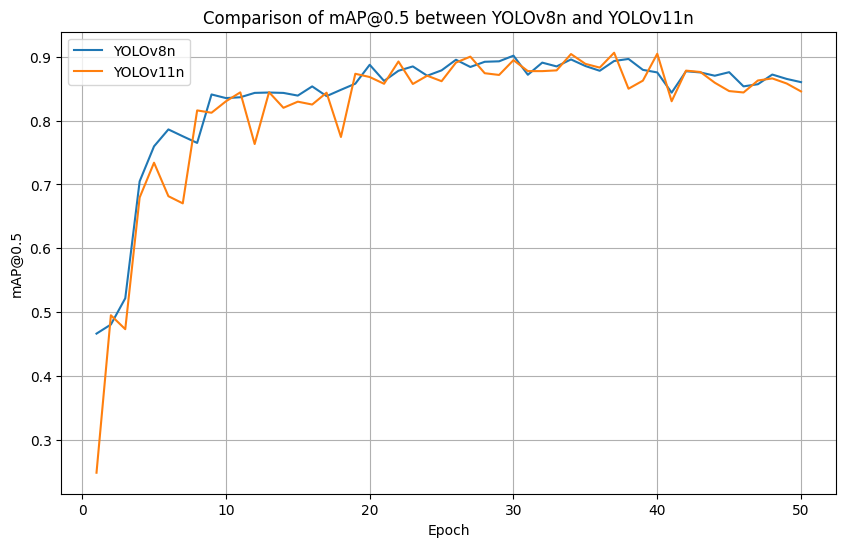

In [36]:
plt.figure(figsize=(10, 6))
plt.plot(results_n['epoch'], results_n['metrics/mAP50(B)'], label='YOLOv8n')
plt.plot(results_s['epoch'], results_s['metrics/mAP50(B)'], label='YOLOv11n')
plt.xlabel('Epoch')
plt.ylabel('mAP@0.5')
plt.title('Comparison of mAP@0.5 between YOLOv8n and YOLOv11n')
plt.legend()
plt.grid(True)
plt.show()


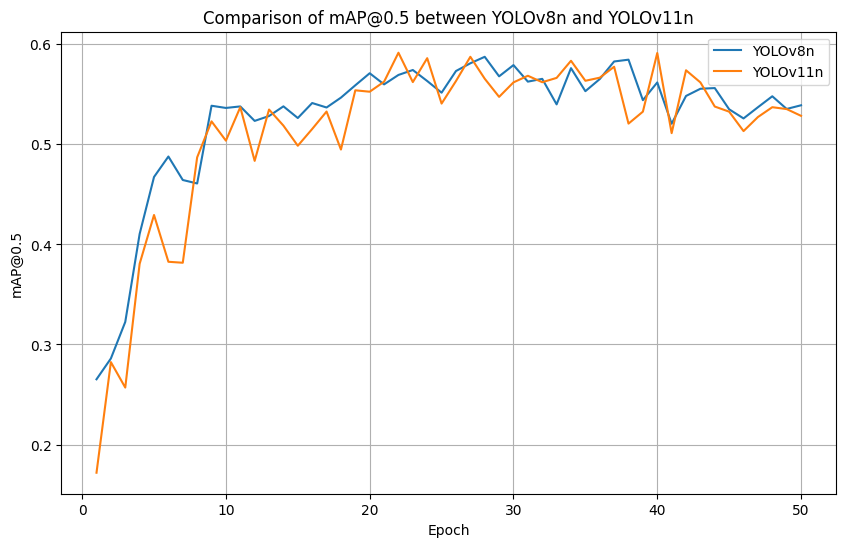

In [38]:
plt.figure(figsize=(10, 6))
plt.plot(results_n['epoch'], results_n['metrics/mAP50-95(B)'], label='YOLOv8n')
plt.plot(results_s['epoch'], results_s['metrics/mAP50-95(B)'], label='YOLOv11n')
plt.xlabel('Epoch')
plt.ylabel('mAP@0.5')
plt.title('Comparison of mAP@0.5 between YOLOv8n and YOLOv11n')
plt.legend()
plt.grid(True)
plt.show()

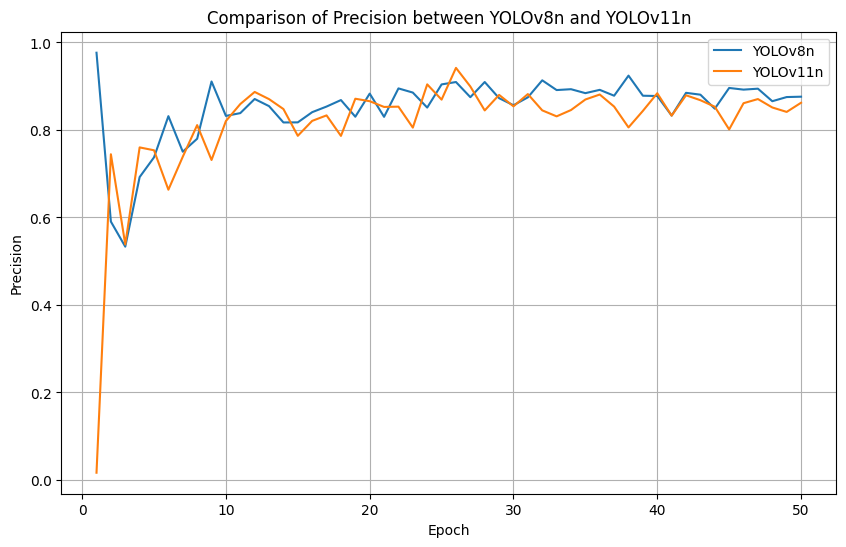

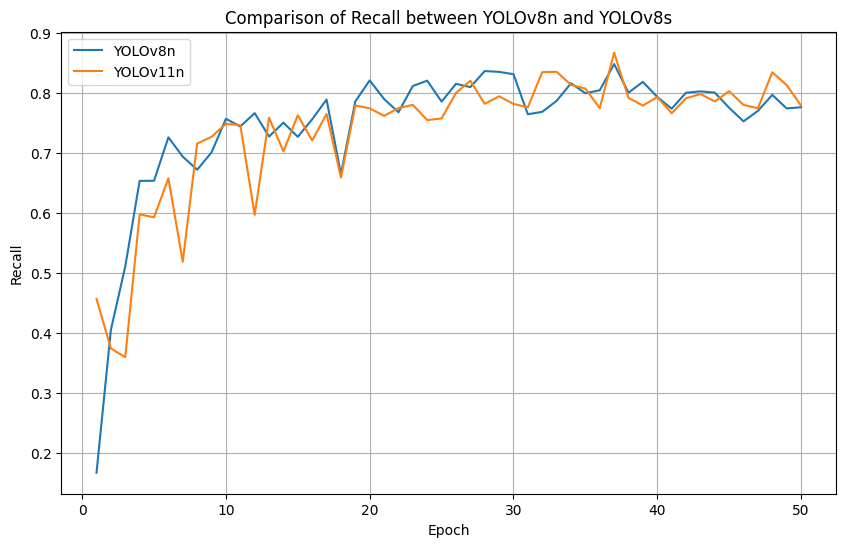

In [42]:
# Plot Precision over epochs
plt.figure(figsize=(10, 6))
plt.plot(results_n['epoch'], results_n['metrics/precision(B)'], label='YOLOv8n')
plt.plot(results_s['epoch'], results_s['metrics/precision(B)'], label='YOLOv11n')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.title('Comparison of Precision between YOLOv8n and YOLOv11n')
plt.legend()
plt.grid(True)
plt.show()

# Plot Recall over epochs
plt.figure(figsize=(10, 6))
plt.plot(results_n['epoch'], results_n['metrics/recall(B)'], label='YOLOv8n')
plt.plot(results_s['epoch'], results_s['metrics/recall(B)'], label='YOLOv11n')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.title('Comparison of Recall between YOLOv8n and YOLOv8s')
plt.legend()
plt.grid(True)
plt.show()


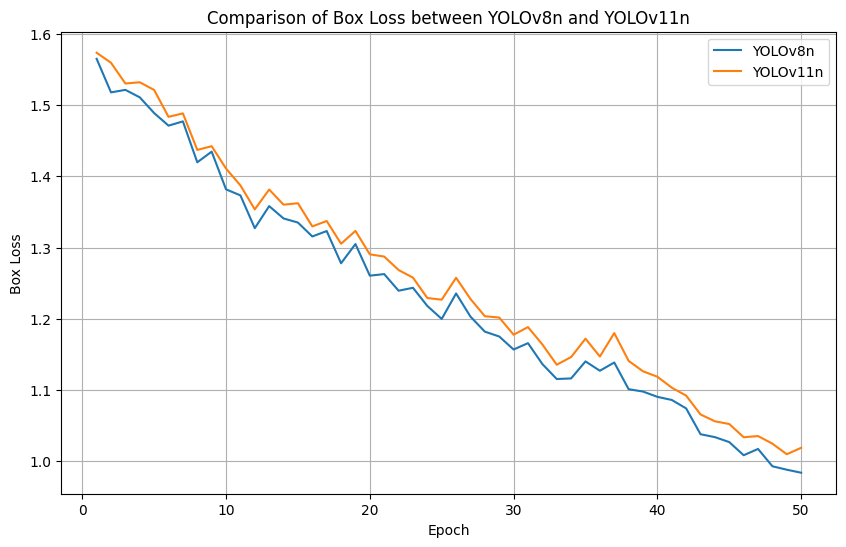

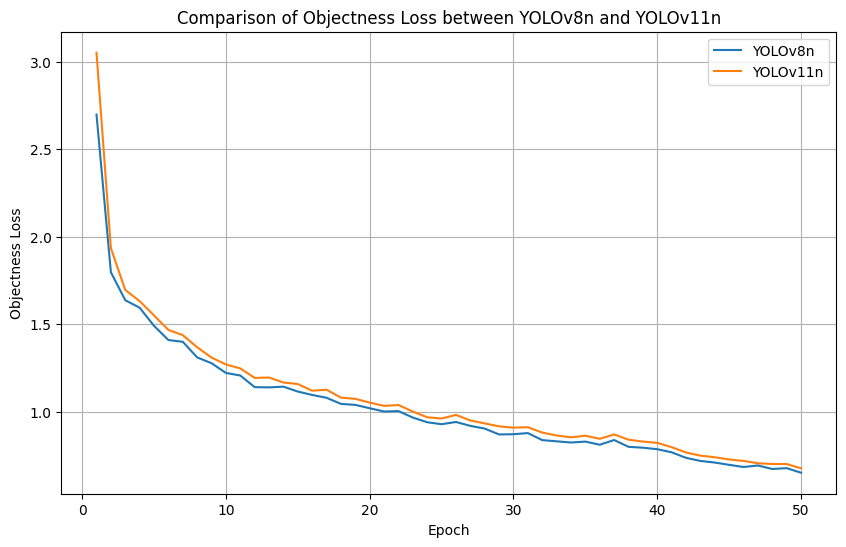

In [45]:
# Plot Box Loss over epochs
plt.figure(figsize=(10, 6))
plt.plot(results_n['epoch'], results_n['train/box_loss'], label='YOLOv8n')
plt.plot(results_s['epoch'], results_s['train/box_loss'], label='YOLOv11n')
plt.xlabel('Epoch')
plt.ylabel('Box Loss')
plt.title('Comparison of Box Loss between YOLOv8n and YOLOv11n')
plt.legend()
plt.grid(True)
plt.show()

# Plot Objectness Loss over epochs
plt.figure(figsize=(10, 6))
plt.plot(results_n['epoch'], results_n['train/cls_loss'], label='YOLOv8n')
plt.plot(results_s['epoch'], results_s['train/cls_loss'], label='YOLOv11n')
plt.xlabel('Epoch')
plt.ylabel('Objectness Loss')
plt.title('Comparison of Objectness Loss between YOLOv8n and YOLOv11n')
plt.legend()
plt.grid(True)
plt.show()


In [48]:
final_n = results_n.iloc[-1]
final_s = results_s.iloc[-1]

# Print final metrics for YOLOv8n
print("YOLOv8n Final Metrics:")
print(f"mAP@0.5: {final_n['metrics/mAP50(B)']:.4f}")
print(f"Precision: {final_n['metrics/precision(B)']:.4f}")
print(f"Recall: {final_n['metrics/recall(B)']:.4f}")

# Print final metrics for YOLOv11n
print("\nYOLOv11n Final Metrics:")
print(f"mAP@0.5: {final_s['metrics/mAP50(B)']:.4f}")
print(f"Precision: {final_s['metrics/precision(B)']:.4f}")
print(f"Recall: {final_s['metrics/recall(B)']:.4f}")


YOLOv8n Final Metrics:
mAP@0.5: 0.8603
Precision: 0.8760
Recall: 0.7766

YOLOv11n Final Metrics:
mAP@0.5: 0.8458
Precision: 0.8621
Recall: 0.7792


In [56]:
!zip -r yolo.zip /kaggle/working/runs


/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


  adding: kaggle/working/runs/ (stored 0%)
  adding: kaggle/working/runs/detect/ (stored 0%)
  adding: kaggle/working/runs/detect/train/ (stored 0%)
  adding: kaggle/working/runs/detect/train/val_batch0_labels.jpg (deflated 18%)
  adding: kaggle/working/runs/detect/train/confusion_matrix.png (deflated 27%)
  adding: kaggle/working/runs/detect/train/train_batch2482.jpg (deflated 16%)
  adding: kaggle/working/runs/detect/train/results.csv (deflated 62%)
  adding: kaggle/working/runs/detect/train/confusion_matrix_normalized.png (deflated 24%)
  adding: kaggle/working/runs/detect/train/results.png (deflated 6%)
  adding: kaggle/working/runs/detect/train/R_curve.png (deflated 8%)
  adding: kaggle/working/runs/detect/train/val_batch0_pred.jpg (deflated 18%)
  adding: kaggle/working/runs/detect/train/train_batch2.jpg (deflated 7%)
  adding: kaggle/working/runs/detect/train/train_batch1.jpg (deflated 5%)
  adding: kaggle/working/runs/detect/train/weights/ (stored 0%)
  adding: kaggle/working/r

In [ ]:
import cv2
import torch
import time
from ultralytics import YOLO

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")


model = YOLO('yolov8_weights/best.pt')  #update path accordingly
model.to(device)

cap = cv2.VideoCapture(0)  

if not cap.isOpened():
    print("Error: Could not open webcam.")
    exit()

cv2.namedWindow('YOLOv8 Live Inference', cv2.WINDOW_NORMAL)
cv2.resizeWindow('YOLOv8 Live Inference', 800, 600)

while True:
    ret, frame = cap.read()
    if not ret:
        print("Failed to grab frame.")
        break

    # Start timer
    start_time = time.time()


    results = model(frame, conf=0.8, iou=0.5, device=device, verbose=False)

    end_time = time.time()
    fps = 1 / (end_time - start_time)

    annotated_frame = results[0].plot()

   
    cv2.putText(annotated_frame, f'FPS: {int(fps)}', (10, 30),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    cv2.imshow('YOLOv8 Live Inference', annotated_frame)

  
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

In [59]:
import cv2
import torch
from ultralytics import YOLO
from tqdm import tqdm
import os

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")


model = YOLO('/kaggle/working/runs/detect/train/weights/best.pt')  
model.to(device)

input_video_path = '/kaggle/input/test-1/videoplayback.mp4'  # Update with your video path
output_video_path = '/kaggle/working/output_video1.mp4'

cap = cv2.VideoCapture(input_video_path)
if not cap.isOpened():
    print("Error: Could not open input video.")
    exit()

frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))


fourcc = cv2.VideoWriter_fourcc(*'mp4v')  
out = cv2.VideoWriter(output_video_path, fourcc, fps, (frame_width, frame_height))

with tqdm(total=total_frames, desc='Processing Video') as pbar:
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        results = model(frame, conf=0.45, iou=0.5, device=device, verbose=False)
        annotated_frame = results[0].plot()
        out.write(annotated_frame)

        pbar.update(1)

cap.release()
out.release()
print(f"Annotated video saved to {output_video_path}")


Using device: cuda


Processing Video: 100%|██████████| 3269/3269 [00:37<00:00, 86.73it/s]

Annotated video saved to /kaggle/working/output_video1.mp4
